In [1]:
from typing import Sequence

import tensorflow as tf

from time_series.dataset.time_series import TrainingDataSet
from time_series.models.transformer import Transformer


class LSTM(Transformer):
    """Forecasting with an LSTM."""

    def __init__(self, data: TrainingDataSet, lstm_units: Sequence[int] = (100,)):
        super().__init__(data)
        self.lstm_units = lstm_units

    def recurrent_layers(self, inputs):
        x = inputs
        for i, dim in enumerate(self.lstm_units):
            x = tf.keras.layers.LSTM(units=dim, return_sequences=True)(x)
        x = tf.keras.layers.Dense(self.data.dimensions)(x)
        return x

    def build_model(self):
        """Build model."""
        inputs = tf.keras.Input(shape=self.data.input_shape)
        lstm_output = self.recurrent_layers(inputs)
        self.model = tf.keras.Model(inputs, lstm_output)
        self.model.compile(
            loss="mse" if self.regression else "sparse_categorical_crossentropy",
            optimizer=tf.keras.optimizers.Adam(),
            metrics=self.metrics,
        )
        print(self.model.summary())


In [2]:
"""Utility functions."""
from typing import Sequence

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras import backend as K
import tensorflow as tf
import numpy as np

from time_series.dataset.time_series import TimeSeries


def set_seed_and_reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


def clear_keras_session():
    K.clear_session()


def evaluate_model(tds: TimeSeries, y_predicted: np.ndarray, columns=Sequence[str], first_n: int = 0):
    """Evaluate the model based on the 1step-ahead prediction"""
    print(f"MSE: {mean_squared_error(y_predicted.reshape(-1,), tds.y_test.reshape(-1,)):.4f}")
    print("----------")
    dimensions = len(columns)
    plt.figure(figsize=(18, 74))
    grid = plt.GridSpec(dimensions, 1 if first_n else 2, wspace=1, hspace=0.5)

    for i in range(dimensions):
        if len(tds.y_train.shape) == 2:
            pred, y_actual = (
                y_predicted[:first_n, i],
                tds.y_test[:first_n, i]
            )
        else:
            pred, y_actual = (
                y_predicted[:first_n, 1, i],
                tds.y_test[:first_n, 1, i]
            )

        ax = plt.subplot(grid[i, 0])
        plt.plot(pred, 'r+--', label="predicted")
        plt.plot(y_actual, 'bo-.', label="actual")
        ax.set_title(list(columns)[i])
        print(f"{columns[i]}: {round(mean_squared_error(y_actual, pred), 2)}")
    plt.legend()


In [4]:
"""Time-series data classes."""
from packaging import version
from dataclasses import dataclass
import logging

import numpy as np
import pandas as pd

if version.parse(np.__version__) >= version.parse("1.20.0"):
    from numpy.typing.np_types import ArrayLike
else:
    from typing import Union

    ArrayLike = Union[np.ndarray, pd.Series, pd.DataFrame]

import tensorflow as tf
from statsmodels.tsa.tsatools import lagmat

from time_series.dataset import Dataset




class TimeSeries(Dataset):
    def __init__(
        self, pandas_df: pd.DataFrame, n_steps: int = 1, batch_size: int = 10,
    ):
        super().__init__()
        assert isinstance(
            pandas_df, (pd.Series, pd.DataFrame)
        ), "Must provide a Pandas df to instantiate this class"
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.dimensions = len(pandas_df.columns)

        data = np.array(pandas_df, dtype=np.float32)
        self.ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.n_steps,
            sequence_stride=1,
            shuffle=True,
            batch_size=self.batch_size,
        )

    def __next__(self):
        """Iterator."""
        return self.ds.next()


def sample_to_input(sample: pd.DataFrame, lag: int, two_dim: bool = False) -> ArrayLike:
    """Reshape a time-series to be suitable for the models.

    Arguments:
        sample (pd.DataFrame): time x value columns.
        lag (int): the number of previous steps to use as predictors.
        two_dim (bool): whether to reshape as 2D (default 3D)
    Output:
        points x time/lag x columns or (for 2D) time x (columns*lag)
    """
    in_dim = sample.shape[1]
    # drop rows with unknown values both at beginning and end
    if two_dim:
        return lagmat(sample.values, maxlag=lag, trim="both")
    else:
        return np.concatenate(
            [
                np.expand_dims(
                    lagmat(sample.values[:, i], maxlag=lag, trim="both"), axis=2
                )
                for i in range(in_dim)
            ],
            axis=2,
        )


@dataclass
class TrainingDataSet:
    """Utility class that can be used for training and testing.

    Create lags and split between train and test.

    Attributes:
         lag, train_split, X_train, y_train, X_test, y_test.
    """

    X_train: ArrayLike
    y_train: ArrayLike
    X_test: ArrayLike
    y_test: ArrayLike

    def __init__(
        self,
        df: pd.DataFrame,
        lag: int = 10,
        train_split: float = 0.8,
        two_dim: bool = False,
    ):
        self.lag = lag
        self.train_split = train_split
        self.two_dim = two_dim
        lagged = sample_to_input(df, lag, two_dim=two_dim)
        y = np.roll(lagged, shift=-lag, axis=0)
        split_point = int(len(df) * train_split)  # points for training
        self.X_train, self.X_test = (
            lagged[:split_point, ...],
            lagged[split_point:, ...],
        )
        self.y_train, self.y_test = (
            y[:split_point, ...],
            y[split_point:, ...],
        )

    @property
    def n_steps(self):
        """How many steps (lags) to use as predictors."""
        return self.X_train.shape[1] if not self.two_dim else 1

    @property
    def dimensions(self):
        """Number of dimensions."""
        return self.X_train.shape[-1]

    @property
    def n_classes(self):
        """Number of classes.

        This is appropriate for classification tasks.
        """
        return len(np.unique(self.y_train))

    @property
    def input_shape(self):
        """The input shape for a model."""
        return self.X_train.shape[1:]

    @property
    def output_shape(self):
        """The input shape for a model."""
        return self.y_train.shape[1:]

    @property
    def exo_dim(self):
        """This class doesn't handle exogenous attributes."""
        return 0

    @property
    def horizon(self):
        """How many steps to forecast to?"""
        return self.y_train.shape[1] if not self.two_dim else 1


In [5]:
import pandas as pd
#import spacetimeformer
data = pd.read_csv('2015年GBDT输入数据集csv版_各网格数量.csv')
%load_ext autoreload
%autoreload 2
data.index = pd.date_range(start="2015-01-01 00:00:00", end="2015-12-31 23:00:00", freq="H")
data

,month,week,hour,weather,temperature,grid1,grid2,grid3,grid4,grid5,...,grid28,grid29,grid30,grid31,grid32,grid33,grid34,grid35,grid36,grid37
2015-01-01 00:00:00,1,4,0,1,-2,322,171,254,410,526,...,1216,175,251,597,374,430,186,189,222,78
2015-01-01 01:00:00,1,4,1,1,-2,426,296,312,426,522,...,1531,229,294,758,457,525,295,240,119,4
2015-01-01 02:00:00,1,4,2,1,-2,415,225,249,385,536,...,1337,120,257,579,312,392,208,191,9,5
2015-01-01 03:00:00,1,4,3,1,-3,315,175,199,454,696,...,827,68,126,341,176,268,116,116,22,3
2015-01-01 04:00:00,1,4,4,1,-3,159,109,122,264,537,...,501,38,93,200,95,125,68,84,25,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-31 19:00:00,12,4,19,1,7,329,182,341,219,222,...,1061,224,271,474,417,340,239,129,353,412
2015-12-31 20:00:00,12,4,20,1,7,339,185,397,248,282,...,1091,246,284,528,435,383,221,178,462,304
2015-12-31 21:00:00,12,4,21,1,7,365,168,351,246,286,...,1106,186,208,528,419,421,210,144,524,370
2015-12-31 22:00:00,12,4,22,1,6,288,175,261,245,343,...,837,174,183,444,372,358,194,135,527,275


In [6]:
%load_ext autoreload
%autoreload 2
from tensorflow.python.framework.ops import disable_eager_execution
import tensorflow as tf

disable_eager_execution()  # for graph mode
tf.compat.v1.experimental.output_all_intermediates(True)
#from time_series.dataset.utils import get_energy_demand
import pandas as pd
import pyreadr
from sklearn.preprocessing import StandardScaler


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
df = data[['grid1', 'grid2',
       'grid3', 'grid4', 'grid5', 'grid6', 'grid7', 'grid8', 'grid9', 'grid10',
       'grid11', 'grid12', 'grid13', 'grid14', 'grid15', 'grid16', 'grid17',
       'grid18', 'grid19', 'grid20', 'grid21', 'grid22', 'grid23', 'grid24',
       'grid25', 'grid26', 'grid27', 'grid28', 'grid29', 'grid30', 'grid31',
       'grid32', 'grid33', 'grid34', 'grid35', 'grid36', 'grid37']]
train_df = pd.DataFrame(data=StandardScaler().fit_transform(df), columns=df.columns, index=df.index)
#tds = TrainingDataSet(df)
tds = TrainingDataSet(df = train_df,lag = 24)

In [8]:

lstm = LSTM(tds)
lstm.instantiate_and_fit(verbose=1, epochs=10)
#y_predicted = lstm.model.predict(tds.X_test, steps=10)
#evaluate_model(first_n=10)
print(lstm.model.evaluate(tds.X_test, tds.y_test))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24, 37)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 24, 100)           55200     
_________________________________________________________________
dense (Dense)                (None, 24, 37)            3737      
Total params: 58,937
Trainable params: 58,937
Non-trainable params: 0
_________________________________________________________________
None
Train on 7008 samples
Epoch 1/10
7008/7008 [==============================] - 1s 192us/sample - loss: 0.2975 - mean_absolute_percentage_error: 373.0654 - mae: 0.3836 - mse: 0.2975
Epoch 2/10
7008/7008 [==============================] - 1s 181us/sample - loss: 0.1517 - mean_absolute_percentage_error: 347.3439 - mae: 0.2675 - mse: 0.1517
Epoch 3/10
7008/7008 [======================

C:\Users\Administrator\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


MSE: 0.1717
----------
grid1: 0.08
grid2: 0.13
grid3: 0.09
grid4: 0.13
grid5: 0.22
grid6: 0.13
grid7: 0.17
grid8: 0.25
grid9: 0.19
grid10: 0.08
grid11: 0.18
grid12: 0.18
grid13: 0.12
grid14: 0.11
grid15: 0.09
grid16: 0.12
grid17: 0.15
grid18: 0.09
grid19: 0.07
grid20: 0.12
grid21: 0.26
grid22: 0.06
grid23: 0.07
grid24: 0.08
grid25: 0.09
grid26: 0.12
grid27: 0.06
grid28: 0.11
grid29: 0.11
grid30: 0.06
grid31: 0.08
grid32: 0.09
grid33: 0.09
grid34: 0.11
grid35: 0.21
grid36: 0.15
grid37: 0.18


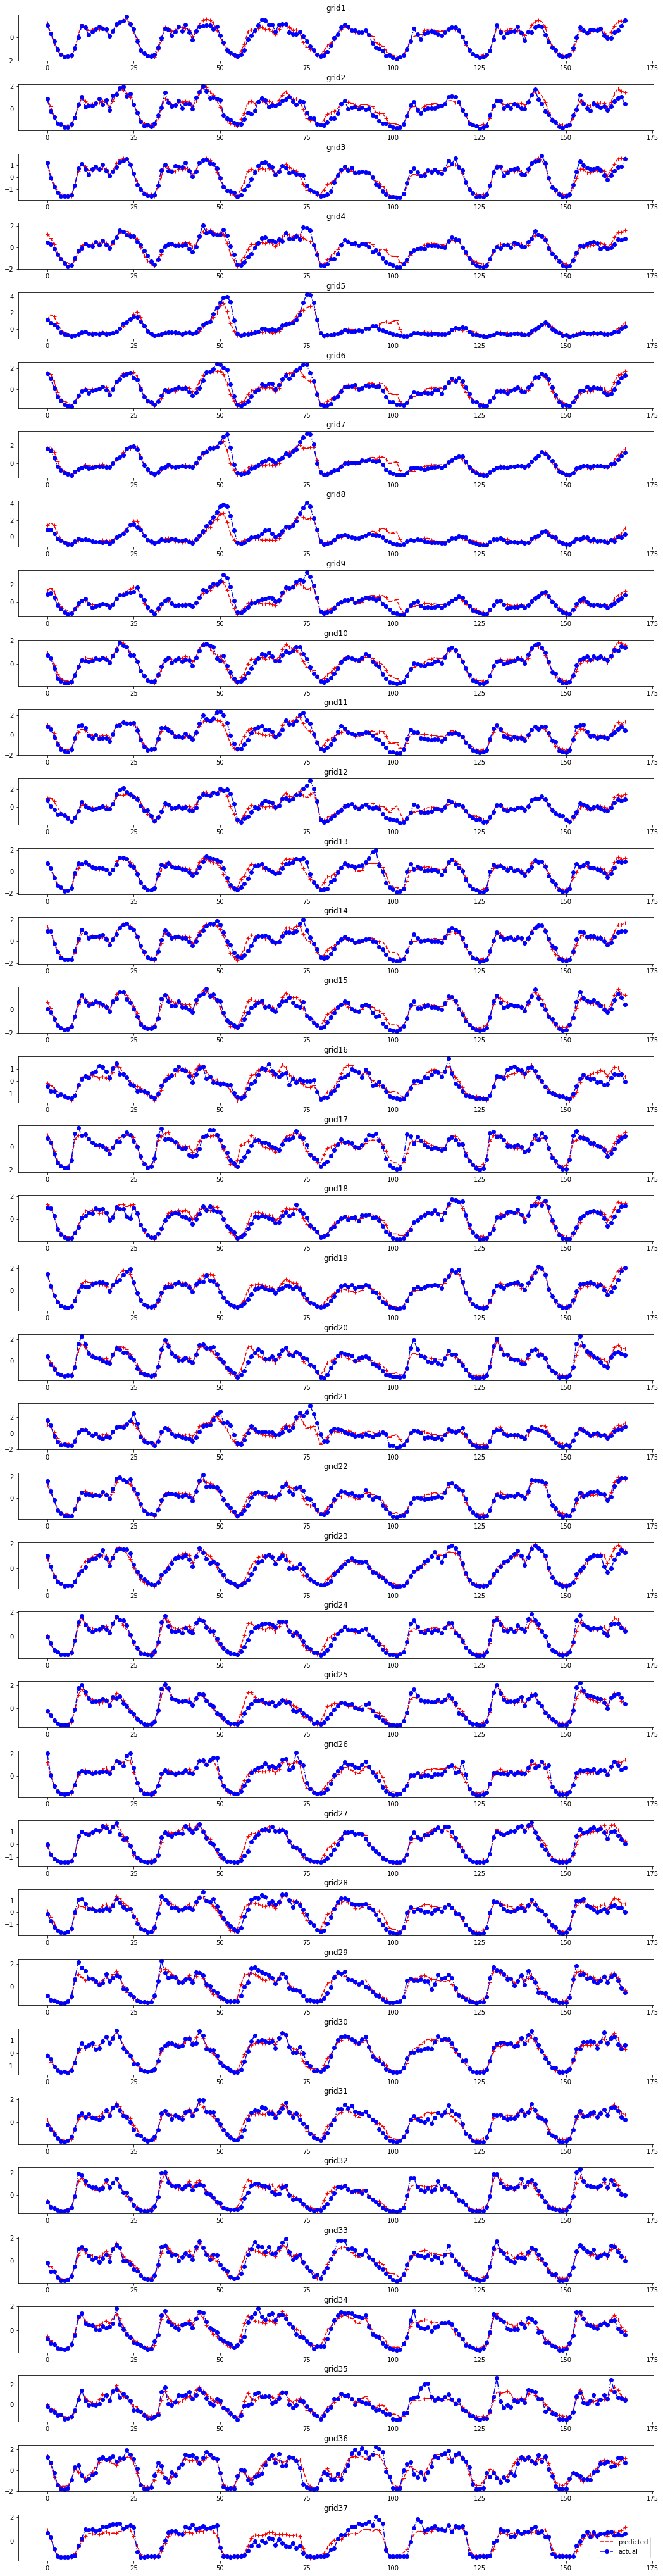

In [9]:

y_predicted = lstm.model.predict(tds.X_test)
evaluate_model(tds=tds, y_predicted=y_predicted, columns=train_df.columns, first_n=24*7)